# Классификация текста - определение сгенерированных текстов.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
train_data = pd.read_csv("fake_or_real_train.csv", index_col='id')
test_data = pd.read_csv("fake_or_real_test.csv", index_col='id')

In [5]:
train_data.head(1)

,text,label
id,,
0,"Фантастический боевик о супергероях, сражающих...",1


## Поработаем с данными 

### Исследуем распределение длины текстов

#### 1) На всём датасете

<Axes: >

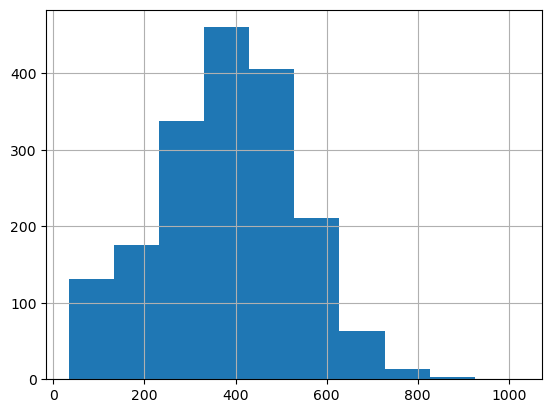

In [8]:
train_data['text'].str.len().hist()

#### 2) Длина аутентичных текстов

<Axes: >

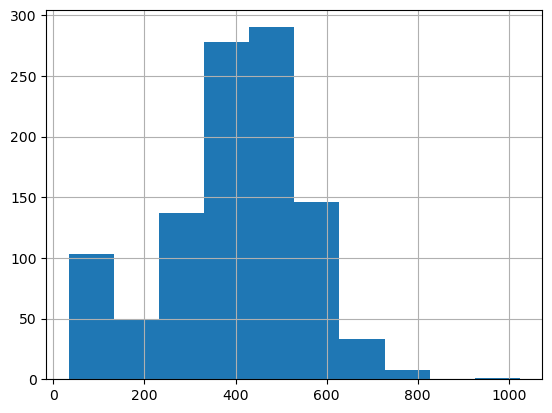

In [10]:
train_data[train_data['label']==1]['text'].str.len().hist()

#### 3) Длина сгенерированных текстов

<Axes: >

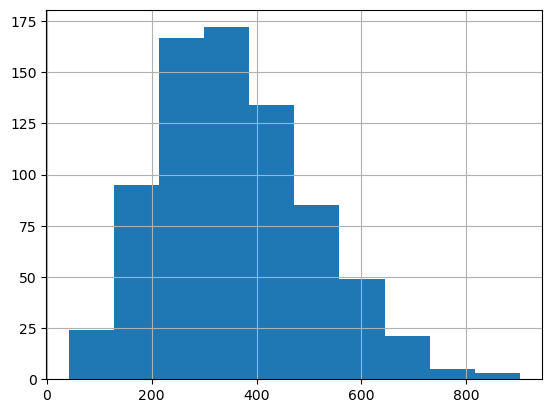

In [11]:
train_data[train_data['label']==0]['text'].str.len().hist()

### Распределение таргета

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='label', ylabel='count'>

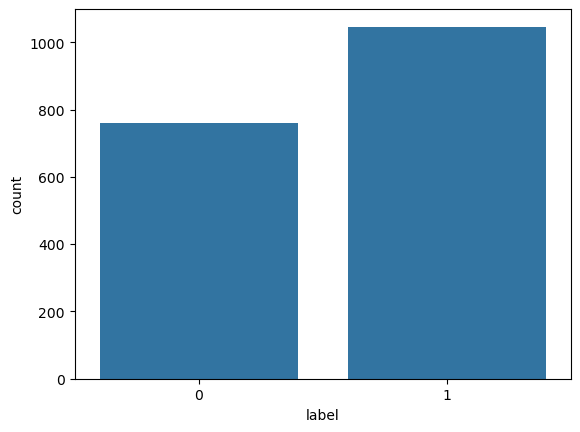

In [13]:
sns.countplot(data=train_data, x='label')

### Пропуски

In [20]:
display(train_data.info())
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1805 entries, 0 to 1804
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1801 non-null   object
 1   label   1805 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1805 to 2304
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    499 non-null    object
dtypes: object(1)
memory usage: 7.8+ KB


None

In [21]:
train_data = train_data.dropna()
test_data = test_data.dropna()

### Разделение выборки

In [24]:
X_train = train_data['text']
y_train = train_data['label']
X_test = test_data['text']

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Работаем 

### Первый вариант: TFIDF + SVM

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_val = vectorizer.transform(X_val).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [29]:
X_train.shape

(1440, 10000)

In [31]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [36]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [40]:
predictions = svm_clf.predict(X_val)
print(accuracy_score(y_val, predictions))
print(f1_score(y_val, predictions))

0.9806094182825484
0.9839816933638444


### Второй вариант: Word2Vec + Catboost

In [54]:
X_train = train_data['text']
y_train = train_data['label']
X_test = test_data['text']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [57]:
X_train_split = [sentence.split() for sentence in X_train]
X_val_split = [sentence.split() for sentence in X_val]

In [58]:
import gensim
from catboost import CatBoostClassifier

In [59]:
word2vec_model = gensim.models.Word2Vec(
    sentences=X_train_split, vector_size=100, window=5, min_count=1, workers=4
)

In [64]:
def vectorize_text(text_data, word2vec_model):
    """
    Функция получения эмбеддингов для набора текстов.
        text_data: набор текстов.
        word2vec_model: обученная модель получения эмбеддингов для слов.
    """
    vectors = []
    for sentence in text_data:
        vector = np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0)
        vectors.append(vector)
    return np.array(vectors)

In [65]:
X_train_w2v = vectorize_text(X_train_split, word2vec_model)
X_val_w2v = vectorize_text(X_val_split, word2vec_model)

In [66]:
X_train_w2v.shape

(1440, 100)

In [68]:
catboost_clf = CatBoostClassifier(iterations=10000, verbose=False)
catboost_clf.fit(X_train_w2v, y_train)

In [69]:
predictions = catboost_clf.predict(X_val_w2v)
print(accuracy_score(y_val, predictions))
print(f1_score(y_val, predictions))

0.7839335180055401
0.8421052631578947


In [72]:
roc_auc_score(y_val, catboost_clf.predict_proba(X_val_w2v)[:, 1])

0.8702772404900065